This article is from [here](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0) and [formula](http://localhost/jforum/posts/list/4741.page)

## <font color='darkblue'>Model Implementation</font>
The complete code is available as a Jupyter Notebook on GitHub
1. Loading data
2. Data Cleaning
3. Phrase Modeling: Bi-grams and Tri-grams
4. Data transformation: Corpus and Dictionary
5. Base Model Performance
6. Hyperparameter Tuning
7. Final Model
8. Visualize Results

### <font color='darkgreen'>Loading Data</font>
For this tutorial, we’ll use the dataset of papers published in NIPS conference. The [NIPS conference](https://en.wikipedia.org/wiki/Conference_on_Neural_Information_Processing_Systems) (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NIPS papers that were published from 1987 until 2016 (29 years!).

Let’s start by looking at the content of the file papers.csv (Download [`NIPS Papers.zip`](https://github.com/kapadias/mediumposts/blob/master/nlp/data/NIPS%20Papers.zip) and unzip it)

In [1]:
# Importing modules
import pandas as pd
import os
import sys

# Show Python version
print(sys.version)

# Read data into papers
papers = pd.read_csv('data/papers.csv')
# Print head
papers.head()

3.6.7 (v3.6.7:6ec5cf24b7, Oct 20 2018, 13:35:33) [MSC v.1900 64 bit (AMD64)]


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


### <font color='darkgreen'>Data Cleaning</font>
Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [2]:
# Remove the columns
papers = papers.drop(columns=['id', 'title', 'abstract', 
                              'event_type', 'pdf_name', 'year'], axis=1)

# sample only 10 papers - for demonstration purposes
papers = papers.sample(10)

# Print out the first rows of papers
papers.head()

,paper_text
1904,"218\n\nBengio, De Mori and Cardin\n\nSpeaker I..."
2138,Interpolating Between Types and Tokens\nby Est...
3524,Adaptive Hedge\n\n?\nPeter Grunwald\n\nTim van...
535,57\n\nSelf Organizing Neural Networks for the\...
4132,Learning in the Vestibular System:\nSimulation...


#### Remove punctuation/lower casing
Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [3]:
# Load the regular expression library
import re
from nltk.stem import PorterStemmer

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Remove none alphabic character(s)
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: re.sub('[~\'(){}:;+-=*"&]', ' ', x))
# Remove number
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: re.sub('[0-9]+', '', x))
# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower().strip())
# Print out the first rows of papers
papers['paper_text_processed'].head()

1904    bengio de mori and cardin\n\nspeaker independe...
2138    interpolating between types and tokens\nby est...
3524    adaptive hedge\n\n\npeter grunwald\n\ntim van ...
535     self organizing neural networks for the\nident...
4132    learning in the vestibular system \nsimulation...
Name: paper_text_processed, dtype: object

In [4]:
# papers['paper_text_processed'][55][:200]

#### Tokenize words and further clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [5]:
%%time
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:100]) # The front 100 words of first article

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


['bengio', 'de', 'mori', 'and', 'cardin', 'speaker', 'independent', 'speech', 'recognition', 'with', 'neural', 'networks', 'and', 'speech', 'knowledge', 'yoshua', 'bengio', 'renato', 'de', 'mori', 'dept', 'computer', 'science', 'dept', 'computer', 'science', 'mcgill', 'university', 'mcgill', 'university', 'montreal', 'canada', 'regis', 'cardin', 'dept', 'computer', 'science', 'mcgill', 'university', 'abstract', 'we', 'attempt', 'to', 'combine', 'neural', 'networks', 'with', 'knowledge', 'from', 'speech', 'science', 'to', 'build', 'speaker', 'independent', 'speech', 'recognition', 'system', 'this', 'knowledge', 'is', 'utilized', 'in', 'designing', 'the', 'preprocessing', 'input', 'coding', 'output', 'coding', 'output', 'supervision', 'and', 'architectural', 'constraints', 'to', 'handle', 'the', 'temporal', 'aspect', 'of', 'speech', 'we', 'combine', 'delays', 'copies', 'of', 'activations', 'of', 'hidden', 'and', 'output', 'units', 'at', 'the', 'input', 'level', 'and', 'back', 'propagatio

### <font color='darkgreen'>Phrase Modeling: Bi-grams and Tri-grams</font>
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: ‘back_bumper’, ‘oil_leakage’, ‘maryland_college_park’ etc.

[**Gensim’s Phrases model**](https://radimrehurek.com/gensim/models/phrases.html) can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are `min_count` and `threshold`. For the parameters below, the higher the values of these param, the harder it is for words to be combined.

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#### Remove Stopwords, Make Bigrams and Lemmatize
The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and [**lemmatization**](https://en.wikipedia.org/wiki/Lemmatisation) and call them sequentially.

In [7]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [33]:
# Optional
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [10]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1][0][:10])

['mori', 'speech', 'dept', 'speech', 'science', 'build', 'speech_recognition', 'system', 'knowledge', 'utilize']


### <font color='darkgreen'>Data Transformation: Corpus and Dictionary</font>
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [11]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:10])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 10), (6, 1), (7, 2), (8, 1), (9, 3)]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of `(word_id, word_frequency)`. For example, (1, 1) above implies, word id 0 occurs one times in the first document. Likewise, word id 2 occurs thrice and so on.

## <font color='darkgreen'>Base Model</font>
We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (<font color='brown'>we’ll use default for the base model</font>).

* **chunksize** controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
* **passes** controls how often we train the model on the entire corpus (<font color='brown'>set to 10</font>). Another word for passes might be “epochs”. iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough.

In [12]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

#### View the topics in LDA model
The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. You can see the keywords for each topic and the weightage(importance) of each keyword using <font color='blue'>lda_model.print_topics()</font>

In [13]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"model" + 0.001*"error" + 0.001*"invite" + 0.001*"state" + '
  '0.001*"set" + 0.001*"network" + 0.001*"function" + 0.001*"output" + '
  '0.001*"list" + 0.001*"result"'),
 (1,
  '0.001*"loss" + 0.001*"number" + 0.001*"result" + 0.001*"set" + '
  '0.001*"model" + 0.001*"use" + 0.001*"action" + 0.001*"probability" + '
  '0.001*"regret" + 0.001*"show"'),
 (2,
  '0.016*"network" + 0.015*"training" + 0.014*"number" + 0.010*"speech" + '
  '0.009*"unit" + 0.009*"output" + 0.009*"input" + 0.009*"pattern" + '
  '0.009*"classifier" + 0.008*"time"'),
 (3,
  '0.022*"network" + 0.021*"figure" + 0.016*"output" + 0.016*"unit" + '
  '0.016*"vor" + 0.015*"normal" + 0.013*"gain" + 0.013*"response" + '
  '0.013*"time" + 0.012*"stage"'),
 (4,
  '0.001*"model" + 0.001*"invite" + 0.001*"set" + 0.001*"loss" + '
  '0.001*"result" + 0.001*"state" + 0.001*"use" + 0.001*"output" + '
  '0.001*"structure" + 0.001*"number"'),
 (5,
  '0.040*"model" + 0.011*"use" + 0.011*"image" + 0.010*"convergence" + '

#### Compute Model Perplexity and Coherence Score
Let’s calculate the baseline coherence score

In [14]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41369518132594835


### <font color='darkgreen'>Hyperparameter Tuning</font>
First, let’s differentiate between model hyperparameters and model parameters :
* **Model hyperparameters** can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics <i>K</i>
* **Model parameters** can be thought of as what the model learns during training, such as the weights for each word in a given topic

Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:
1. Number of Topics (<i>K</i>)
2. Dirichlet hyperparameter alpha: Document-Topic Density
3. Dirichlet hyperparameter beta: Word-Topic Density

We’ll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two different validation corpus sets. We’ll use `C_v` as our choice of metric for performance comparison

In [15]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

Let’s call the function, and iterate it over the range of topics, alpha, and beta parameter values

In [17]:
%%time
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    loop_num = len(corpus_sets) * len(topics_range) * len(alpha) * len(beta)
    pbar = tqdm.tqdm(total=loop_num)
    
    # iterate through validation corpuses
    iter_i = 0
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                                        
                    pbar.update(1)                    
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 11%|█████████                                                                        | 30/270 [04:18<33:50,  8.46s/it]c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [40:53<00:00,  9.09s/it]

Wall time: 40min 53s


### <font color='darkgreen'>Investigate Results</font>
Let’s start by determining the optimal number of topics. The chart below outlines the coherence score, `C_v`, for the number of topics across two validation sets, and a fixed alpha = 0.01 and beta = 0.01

In [21]:
# Prepare the data for drawing chart
target_alpha = 0.01
target_beta = 0.01
topic_nums = list(range(2, 11))
target_co_pos_set = set()
for i, t in enumerate(zip(model_results['Alpha'], model_results['Beta'])):
    if t[0] == target_alpha and t[1] == target_beta:
        target_co_pos_set.add(i)
        
coherences = []
for i, co in enumerate(model_results['Coherence']):
    if i in target_co_pos_set:
        coherences.append(co)
        
for topic_num, coherence in zip(topic_nums, coherences):
    print("Topic number={} with coherence value={:.02f}".format(topic_num, coherence))

Topic number=2 with coherence value=0.27
Topic number=3 with coherence value=0.34
Topic number=4 with coherence value=0.42
Topic number=5 with coherence value=0.44
Topic number=6 with coherence value=0.45
Topic number=7 with coherence value=0.38
Topic number=8 with coherence value=0.39
Topic number=9 with coherence value=0.46
Topic number=10 with coherence value=0.39


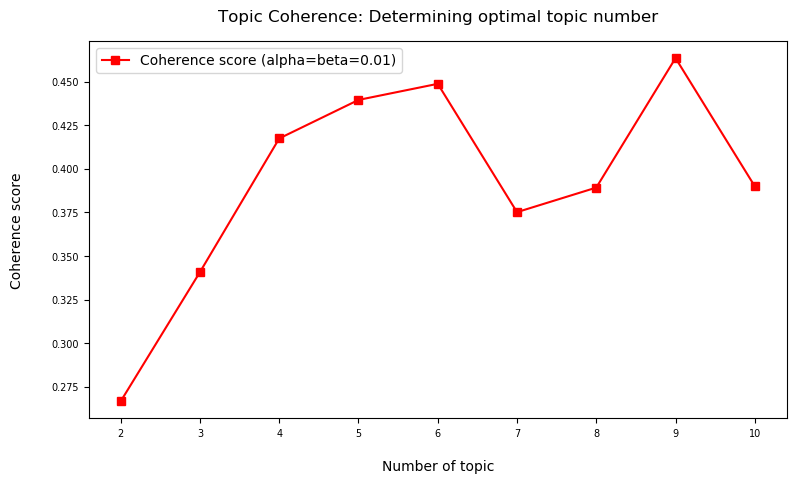

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5), dpi=100, linewidth = 2)
plt.plot(topic_nums, coherences, 's-', color = 'r', label="Coherence score (alpha=beta=0.01)")
plt.title("Topic Coherence: Determining optimal topic number", x=0.5, y=1.03)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel("Number of topic", fontsize=10, labelpad = 15)
plt.ylabel("Coherence score", fontsize=10, labelpad = 20)

plt.legend(loc = "best", fontsize=10)
plt.show()

With the coherence score seems to keep increasing with the number of topics, **it may make better sense to pick the model that gave the highest <font color='violet'>CV</font> before flattening out or a major drop**. In this case, we picked K=9. Next, we want to select the optimal alpha and beta parameters. While there are other sophisticated approaches to tackle the selection process, for this tutorial, we choose the values that yielded maximum <font color='violet'>C_v</font> score for K=9:

In [30]:
target_topic_num = 9
target_collection = []
for k, a, b, c in zip(model_results['Topics'], model_results['Alpha'], model_results['Beta'], model_results['Coherence']):
    if k == target_topic_num:
        target_collection.append((a, b, c))
        
target_collection = sorted(target_collection, key=lambda t: t[2], reverse=True)
target_collection[:10]

[(0.01, 0.61, 0.4668364721990676),
 (0.31, 0.61, 0.4668364721990676),
 ('symmetric', 0.61, 0.4668364721990676),
 (0.01, 0.31, 0.4659944830252864),
 (0.01, 'symmetric', 0.4659944830252864),
 (0.31, 0.31, 0.4659944830252864),
 (0.31, 'symmetric', 0.4659944830252864),
 ('symmetric', 0.31, 0.4659944830252864),
 ('symmetric', 'symmetric', 0.4659944830252864),
 ('asymmetric', 0.01, 0.4659944830252864)]

In [34]:
# Optional
# !pip install plotly

In [38]:
import plotly.graph_objects as go

a_values = []
b_values = []
c_values = []
for a, b, c in target_collection[:10]:
    a_values.append(a)
    b_values.append(b)
    c_values.append(c)
    
fig = go.Figure(data=[
                        go.Table(header=dict(values=['Alpha', 'Eta', 'Coherence']),
                        cells=dict(values=[a_values, b_values, c_values]))
                     ])
fig.show()

That yields approx. 13% improvement over the baseline score with setting Alpha=0.01, Eta=0.61, K=9:

In [37]:
best_co = target_collection[0][2]
improve_pert = (best_co - coherence_lda) * 100 / coherence_lda
print("Coherence score is improved by {:.01f}%".format(improve_pert))

Coherence score is improved by 12.8%


### <font color='darkgreen'>Final Model</font>
Let’s train the final model using the above selected parameters:

In [39]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.61)

### <font color='darkgreen'>Visualize Topics</font>

In [40]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.090748 -0.027611       1        1  27.459574
5      0.027515 -0.059084       2        1  22.538763
2     -0.004834 -0.067637       3        1  18.204256
0      0.050164  0.088480       4        1  11.841822
8      0.019869  0.009855       5        1  11.642356
3     -0.098431 -0.010797       6        1   8.311237
6     -0.029022  0.022103       7        1   0.000665
4     -0.027508  0.022630       8        1   0.000665
1     -0.028502  0.022062       9        1   0.000665, topic_info=     Category        Freq         Term       Total  loglift  logprob
295   Default  185.000000        model  185.000000  30.0000  30.0000
2056  Default   51.000000       invite   51.000000  29.0000  29.0000
514   Default   47.000000         word   47.000000  28.0000  28.0000
2086  Default   35.000000         norm   35.000000  27.0000  27.0000
313   Default   65.000000      network   65.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
940    Topic9    0.000043  convergence   31.569017  -1.5934  -7.7597
331    Topic9    0.000043    parameter   52.445946  -2.0962  -7.7549
198    Topic9    0.000043       follow   43.713749  -1.9175  -7.7583
313    Topic9    0.000043      network   65.418175  -2.3209  -7.7586
55     Topic9    0.000043         case   30.834217  -1.5702  -7.7600

[619 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1330      6  0.373505  ablation
1926      1  0.857035    absorb
1164      2  0.702002    accept
5         3  0.801184  acoustic
890       1  0.965683    action
...     ...       ...       ...
516       2  0.175731     would
516       3  0.117154     would
516       6  0.234308     would
2414      4  0.606046       xij
1529      6  0.373500      yagi

[809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 3, 1, 9, 4, 7, 5, 2])